<a href="https://colab.research.google.com/github/apadros01/BMW-Pricing-Challenge/blob/main/BMW_pricing_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Àlex Padrós Zamora

Github: https://github.com/apadros01

LinkedIn: https://www.linkedin.com/in/alexpadroszamora/

Link of the Kaggle competition: https://www.kaggle.com/danielkyrka/bmw-pricing-challenge

This notebook has been written in Google Colab.

**Context**

Estimating the value of a used car is one of the main everyday challenges in automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability and politics.
With this challenge we hope to raise some interest in this exciting topic and also gain some insight in what the main factors are that drive the value of a used car.

**Content**

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of car that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## Read the data

In [ ]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime

In [ ]:
file_route = '/content/drive/MyDrive/HP/data_pricing_challenge.csv'
data = pd.read_csv(file_route)
print(data.shape)
df=data.copy()
df_t = data.copy()
df.head()

(4843, 18)


,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2/1/2012,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,1/1/2018
1,BMW,M4,13929,317,4/1/2016,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2/1/2018
2,BMW,320,183297,120,4/1/2012,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2/1/2018
3,BMW,420,128035,135,7/1/2014,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2/1/2018
4,BMW,425,97097,160,12/1/2014,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,4/1/2018


## Data insights

First of all, let's start by understanding the dataset and its insights

Observe that there are not null values:

In [ ]:
df.isna().sum()

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64

We have three quantitative features: *mileage*,*engine_power*,*price*. 

In [ ]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


Observe that there are some rows that contain values that do not make sense. For instance, mileage can not be negative, or the engine power must be strictly positive. We remove these kind of rows, since there are only two:

In [ ]:
df[(df.mileage<=0) | (df.engine_power<=0)]

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
2938,BMW,640 Gran Coupé,-64,230,3/1/2017,diesel,black,sedan,True,True,False,True,False,False,True,True,75000,4/1/2018
3765,BMW,X1,81770,0,10/1/2014,diesel,white,suv,False,False,False,False,False,False,False,False,11700,3/1/2018


In [ ]:
df.drop(df[df.mileage <= 0].index,inplace=True)
df.drop(df[df.engine_power <= 0].index,inplace=True)

We add the age of each car at the moment what it was sold, calculated in days:

In [ ]:
old = []
sold_at = []
for date in df['registration_date']:
  old.append(datetime.strptime(date,"%m/%d/%Y"))

for date in df['sold_at']:
  sold_at.append(datetime.strptime(date,"%m/%d/%Y"))

ages=[]
for i in range(len(old)):
  diff = sold_at[i].date() - old[i].date()
  ages.append(np.int(diff.days))

df['Age'] = np.array(ages)

In [ ]:
df.dtypes

maker_key            object
model_key            object
mileage               int64
engine_power          int64
registration_date    object
fuel                 object
paint_color          object
car_type             object
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
price                 int64
sold_at              object
Age                   int64
dtype: object

For the quantitative variables, let's see how the ranges are distributed:

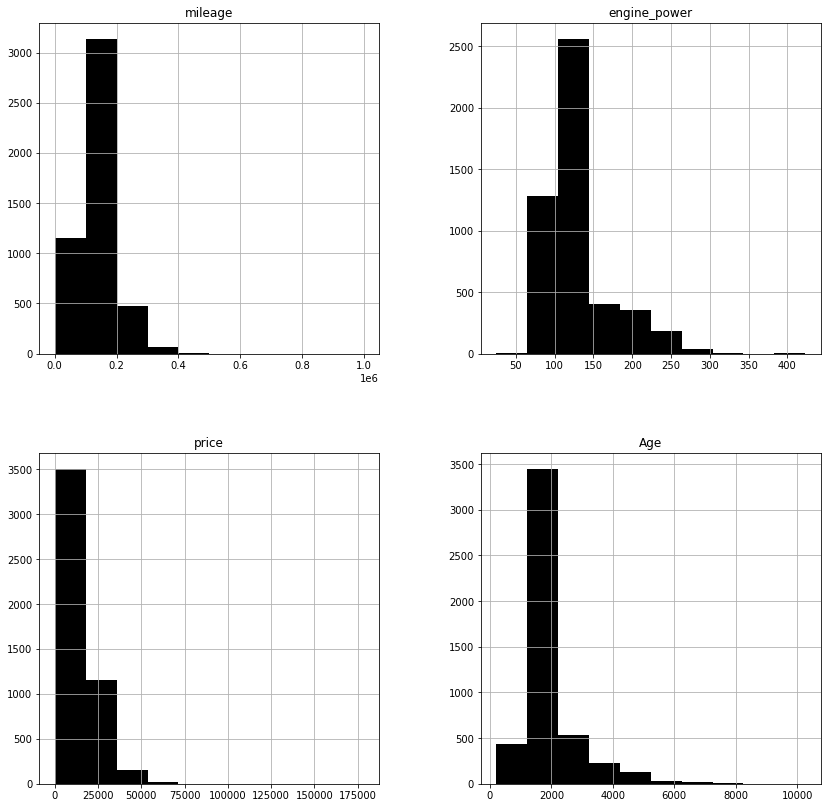

In [ ]:
df.hist(color="k",figsize=(14,14))
plt.show()

All of these features have a clearly dominant value, the one that seems to be more normally distributed is the age.

Let's see the distribution of the qualitative features:

In [ ]:
def histograms(column,name,color=(0.1, 0.1, 0.1, 0.1)):
  fig = plt.figure(figsize=(6,6))
  c = column.value_counts()
  c.sort_values(ascending=False).plot.bar(width=0.5,color=color,edgecolor='b',align='center',linewidth=1)
  plt.xlabel(name)
  plt.ylabel('Counts')
  plt.title('Count of '+str(name),fontsize=10)
  plt.show()

The majority of cars are of type *estate*, *sedan* and *suv*:

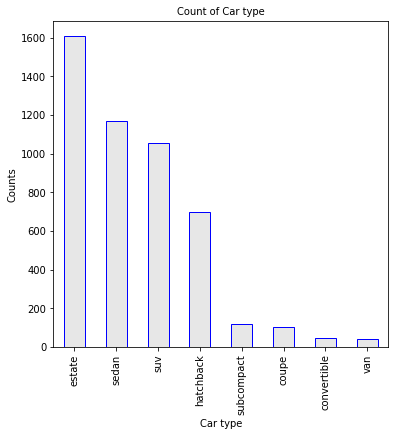

In [ ]:
histograms(df['car_type'],'Car type')

Most of the cars are of *diesel* fuel:

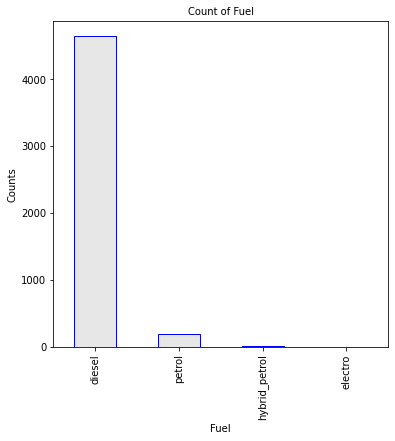

In [ ]:
histograms(df['fuel'],'Fuel')

For the colors, the majority are black, grey and blue:

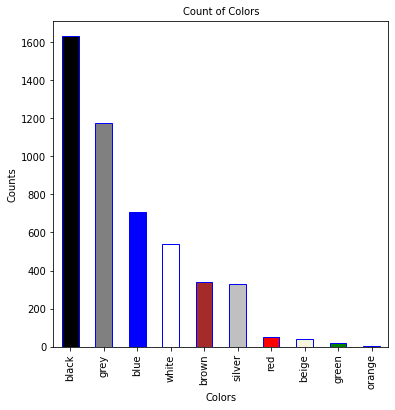

In [ ]:
cols = ['black','grey','blue','white','brown','silver','red','beige','green','orange']
histograms(df['paint_color'],'Colors',color=cols)

Let's see if there's actually some degree of linear dependence for any pair of variables. In order to see this, we will plot the correlation matrix, where each component represents the Pearson's correlation coefficient for each pair of variables. This is defined as:

$$ \text{corr}(X,Y)  = \frac{E \left[ \left( X - \mu_X \right) \left( Y - \mu_Y \right)\right]}{\sigma_X \sigma_Y},$$
where $\mu$ denotes the expected values, $E$ is the expected value operator and $\sigma$ the standard deviations.

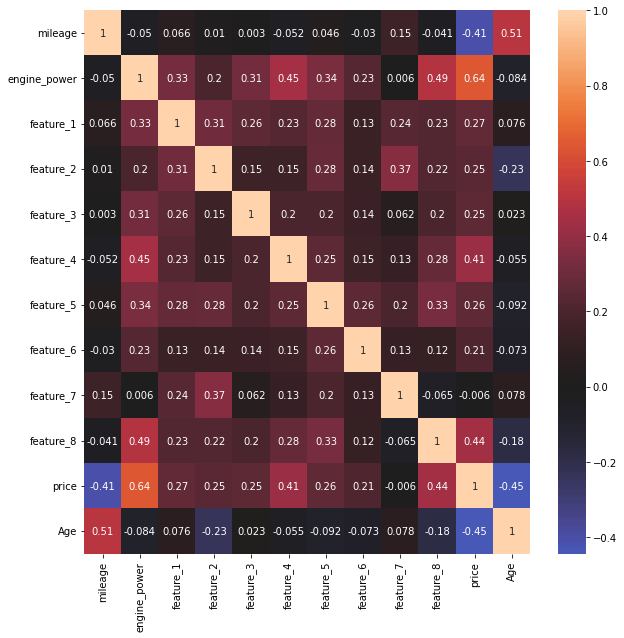

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr().round(3),center=0, annot=True)
plt.show()

From all these Pearson correlation coefficients, we deduce that:

*   The correlation between *price* and *engine_power* is $0.64$, which means they’re strongly positively correlated. More engine power is strongly related to higher prices. 
*   Another remarkable correlation, which seems logical, is between Age and mileage. The correlation is $0.51$. More age is related to higher mileage.
*  The feature *price* has two significant negative correlations with *mileage* and *Age*, which are $-0.41$ and $-0.45$ respectively. These indicate that more age or mileage are associated with less price.
*   Regarding the features, the ones which are more correlated with the price are the 4-th and 8-th.



## 1 - What are the most important characteristics and features that determine the selling price of a used car? 

We have two columns, *registration_date* and *sold_at*, which refer to dates. Observe that the column *sold_at* is clearly not relevant for determining the selling price, so we will remove it. In addition, we no longer need the "registation_date" column, so we remove it too.

In [ ]:
df.drop('sold_at',axis=1,inplace=True)
df.drop('registration_date',axis=1,inplace = True)

We encode for the columns *maker_key*, *fuel*, *paint_color*, *car_type*, which are basically columns of labels:

In [ ]:
le = LabelEncoder()
df['model_key'] =le.fit_transform(df['model_key'])+1
df['fuel'] = le.fit_transform(df['fuel'])+1
df['paint_color'] = le.fit_transform(df['paint_color'])+1
df['car_type'] = le.fit_transform(df['car_type'])+1

In [ ]:
print(df.shape)
df.head()

(4841, 17)


,maker_key,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,Age
0,BMW,3,140411,100,1,2,1,True,True,False,False,True,True,True,False,11300,2161
1,BMW,62,13929,317,4,6,1,True,True,False,False,False,True,True,True,69700,671
2,BMW,22,183297,120,1,10,1,False,False,False,False,True,False,True,False,10200,2132
3,BMW,32,128035,135,1,8,1,True,True,False,False,True,True,True,True,25100,1311
4,BMW,34,97097,160,1,9,1,True,True,False,False,False,True,True,True,33400,1217


**Observation:** The column *maker_key* only contains the label 'BMW', so we remove it since it will not add any value to our analysis. 

In [ ]:
print(np.unique(df.maker_key))
df.drop('maker_key',axis=1,inplace=True)

['BMW']


In [ ]:
df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,Age
0,3,140411,100,1,2,1,True,True,False,False,True,True,True,False,11300,2161
1,62,13929,317,4,6,1,True,True,False,False,False,True,True,True,69700,671
2,22,183297,120,1,10,1,False,False,False,False,True,False,True,False,10200,2132
3,32,128035,135,1,8,1,True,True,False,False,True,True,True,True,25100,1311
4,34,97097,160,1,9,1,True,True,False,False,False,True,True,True,33400,1217


In [ ]:
df.dtypes

model_key       int64
mileage         int64
engine_power    int64
fuel            int64
paint_color     int64
car_type        int64
feature_1        bool
feature_2        bool
feature_3        bool
feature_4        bool
feature_5        bool
feature_6        bool
feature_7        bool
feature_8        bool
price           int64
Age             int64
dtype: object

All the feature columns are booleans, so we convert them into $1$s and $0$s:

In [ ]:
for i in range(1,9):
  df['feature_'+str(i)]=df['feature_'+str(i)]*1
  df['feature_'+str(i)]=df['feature_'+str(i)].astype(int)

In [ ]:
df.dtypes

model_key       int64
mileage         int64
engine_power    int64
fuel            int64
paint_color     int64
car_type        int64
feature_1       int64
feature_2       int64
feature_3       int64
feature_4       int64
feature_5       int64
feature_6       int64
feature_7       int64
feature_8       int64
price           int64
Age             int64
dtype: object

We save the target and remove it from the dataset:

In [ ]:
prices = df.price.copy()
df.drop('price',inplace=True,axis = 1)

In order to determine which are the most important features, we will train some ML models and then apply [Permutation Feature Importance](https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9) (see the appendix for the description of this algorithm):

**REMARK:** All of the out-of-sample accuracy metrics that we will use will be Root Mean Squared Error (RMSE). This is defined as:

$$ \text{RMSE}:= \sqrt{ \frac{\sum_{i=1}^{N} \left( \hat{x}_i - x_i \right)^2}{N} },  $$

where $N$ is the number of data points, $x_i$ the actual observations and $\hat{x}_i$ the predictions.

We start with Gradient Boosting Regression:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, prices, test_size=0.15)

In [ ]:
def get_feature_importances(X,y,model,score='neg_mean_squared_error'):
    results = permutation_importance(model, X, y, scoring=score)
    return results.importances_mean

def plot_feature_importances(X,importance,title):
  # plot feature importance
  plt.barh([x for x in X.columns],importance)
  plt.xticks(range(0,len(importance)))
  plt.title(title)
  plt.show()

In [ ]:
modelGBR = GradientBoostingRegressor(loss ='squared_error',n_estimators=150, max_depth=7,max_leaf_nodes = 9)
modelGBR.fit(X_train, y_train)
prediction = modelGBR.predict(X_test)
error = mean_squared_error(prediction, y_test)
print('RMSE for Gradient Boosting Regressor:',np.sqrt(error))
print('Coefficient of determination of the prediction: ',modelGBR.score(X_test, y_test))

RMSE for Gradient Boosting Regressor: 2547.1679426691026
Coefficient of determination of the prediction:  0.9089856343608794


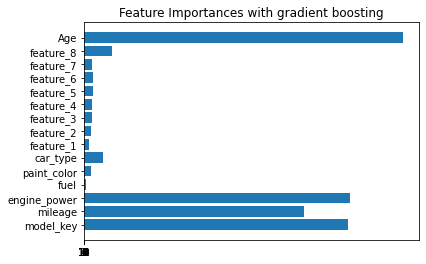

In [ ]:
importances = get_feature_importances(X_train,y_train,modelGBR)
plot_feature_importances(X_train,importances,'Feature Importances with gradient boosting')

Now, let's try with K-nearest neighbors:

In [ ]:
modelKN = KNeighborsRegressor(n_neighbors=7,weights='distance',p=1)
modelKN.fit(X_train, y_train)
prediction = modelKN.predict(X_test)
error = mean_squared_error(prediction, y_test)
print('RMSE for K-nearest neighbors with K=7: ',np.sqrt(error))
print('Coefficient of determination of the prediction: ',modelKN.score(X_test, y_test))

RMSE for K-nearest neighbors with K=7:  6998.770311238578
Coefficient of determination of the prediction:  0.31287101664960904


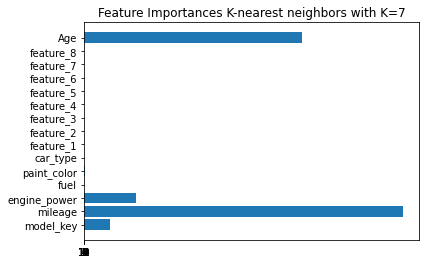

In [ ]:
importances = get_feature_importances(X_train,y_train,modelKN)
plot_feature_importances(X_train,importances,'Feature Importances K-nearest neighbors with K=7')

The results with K-nearest neighbors haven't been very promising.

We now try it with Random Forest Regressor:

In [ ]:
modelRF = RandomForestRegressor(n_estimators=200,min_samples_split=5)
modelRF.fit(X_train, y_train)
prediction = modelRF.predict(X_test)
error = mean_squared_error(prediction, y_test)
print('RMSE for Random Forest Regressor: ',np.sqrt(error))
print('Coefficient of determination of the prediction: ',modelRF.score(X_test, y_test))

RMSE for Random Forest Regressor:  3030.4175855301437
Coefficient of determination of the prediction:  0.8711751216701217


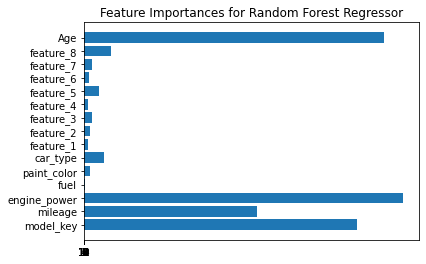

In [ ]:
importances = get_feature_importances(X_train,y_train,modelRF)
plot_feature_importances(X_train,importances,'Feature Importances for Random Forest Regressor')

Finally, with a Decision Trees Regressor:

In [ ]:
modelDT = DecisionTreeRegressor(max_depth=35,min_samples_split=7,min_samples_leaf=5)
modelDT.fit(X_train, y_train)
prediction = modelDT.predict(X_test)
error = mean_squared_error(prediction, y_test)
print('RMSE for Random Forest Regressor: ',np.sqrt(error))
print('Coefficient of determination of the prediction: ',modelDT.score(X_test, y_test))

RMSE for Random Forest Regressor:  3673.0043921625124
Coefficient of determination of the prediction:  0.8107492186533741


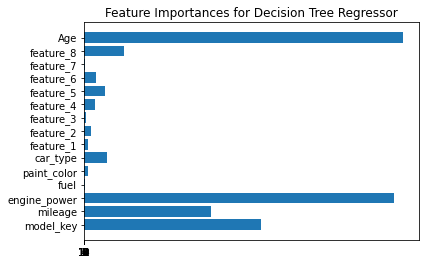

In [ ]:
importances = get_feature_importances(X_train,y_train,modelDT)
plot_feature_importances(X_train,importances,'Feature Importances for Decision Tree Regressor')

Clearly, all the experiments, whether they have achieved good or bad results, have shown that the most important features are **engine_power**, **mileage**, **model_key** and **Age**.

# 2.How does the estimated value of a car change over time? 

a.Does a relative change in selling price over time differ significantly with respect to any of the car characteristics, e.g., color, price range or features? 

b.Are there any statistically significant seasonality patterns in pricing, e.g. certain car types being more expensive in summer than winter?

We start by correcting the format of the dates:

In [ ]:
df_t['sold_at'] = pd.to_datetime(df_t.sold_at)
df_t['sold_at'] = df_t['sold_at'].dt.strftime('%d/%m/%Y')
df_t['registration_date'] = pd.to_datetime(df_t.registration_date)
df_t['registration_date'] = df_t['registration_date'].dt.strftime('%d/%m/%Y')

In [ ]:
df_t.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,01/02/2012,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,01/01/2018
1,BMW,M4,13929,317,01/04/2016,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,01/02/2018
2,BMW,320,183297,120,01/04/2012,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,01/02/2018
3,BMW,420,128035,135,01/07/2014,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,01/02/2018
4,BMW,425,97097,160,01/12/2014,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,01/04/2018


In [ ]:
# this cell is needed for the tableau visualization
# df_t.to_csv('tableau_data_pricing_challenge.csv',index=False)

In [ ]:
def plot_feature(data,feature):
  line = alt.Chart(data).mark_line().encode(
    x='sold_at',
    y='mean(price)',
    color=alt.Color(feature, scale=alt.Scale(scheme='dark2'))
  ).properties(title='Avg. Price by '+str(feature))
  return line

def plot_all_charts(data):
  return (plot_feature(data,'feature_1') | plot_feature(data,'feature_2') | plot_feature(data,'feature_3')) & (plot_feature(data,'feature_4') | plot_feature(data,'feature_5') | plot_feature(data,'feature_6')) & (plot_feature(data,'feature_7') | plot_feature(data,'feature_8'))



For cars priced under 10,000€ we observe that the average selling price slightly increases over time: 

In [ ]:
df_under_10k = df_t[df_t.price<=10000]
line = alt.Chart(df_under_10k).mark_line().encode(x='sold_at',y='mean(price)').properties(title='Cars of price range 0 - 10.000 € ')
line

alt.Chart(...)

For cars with a price range of 10.000 - 20.000 there's not a significance difference over time: 

In [ ]:
df_10k_20k = df_t[(df_t.price>=10000)&(df_t.price<=20000)]
line = alt.Chart(df_10k_20k).mark_line().encode(x='sold_at',y='mean(price)').properties(title='Cars between 10.000 - 20.000 € ')
line

alt.Chart(...)

For cars over 20.000€, we clearly see a notable increase over time in the selling price:

In [ ]:
df_over_20k = df_t[(df_t.price>=20000)]
line = alt.Chart(df_over_20k).mark_line().encode(x='sold_at',y='mean(price)').properties(title='Cars over 20.000 € ')
line

alt.Chart(...)

Filtering by cars with a price over 20.000€, we plot the evolution of the average price by each of the features, which are all booleans:

In [ ]:
plot_all_charts(df_over_20k)

alt.VConcatChart(...)

There are many interesting things that we can see in some of the plots:


*   For this type of cars (over 20.000€), the price increases significantly over time when feature 3 is TRUE.
*   It happens the same when features 5 or 7 are FALSE

Regarding other features such as Car Type or Paint color, we have created some Tableau Dashboards in order to make the charts more interactive and extract some conclusions. Here's the Tableau link for the visualization of the evolution plots:

https://public.tableau.com/app/profile/.lex5167/viz/HP2_16438391082760/PaintColor_1


From the evolution chart by Car Type, we can observe some interesting points:


*   Cars of type "coupe" are much cheaper in Spring or Summer than in Winter.
*   Cars of type "van" increase their price as the heat arrives.
*   Cars of type "convertible" decrease their price as the heat arrives.

Below we can see the exact figures:

In [ ]:
df_t['sold_at']=pd.to_datetime(df_t.sold_at)

In [ ]:
df_winter = df_t[df_t.sold_at.dt.day.isin([1,2,3])]
df_spring = df_t[df_t.sold_at.dt.day.isin([4,5,6])]
df_summer = df_t[df_t.sold_at.dt.day.isin([7,8,9])]

In [ ]:
print('---------- WINTER ------------')
pd.pivot_table(df_winter[df_winter['car_type'].isin(['convertible','coupe','van'])],index='car_type',columns='sold_at',values='price',aggfunc='mean',margins=True).round()


---------- WINTER ------------


sold_at,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,All
car_type,,,,
convertible,11300.0,23433.0,19017.0,20462.0
coupe,17125.0,32638.0,25692.0,26544.0
van,NaN,9675.0,9000.0,9386.0
All,15960.0,24467.0,21595.0,22118.0


In [ ]:
print('---------- SPRING ------------')
pd.pivot_table(df_spring[df_spring['car_type'].isin(['convertible','coupe','van'])],index='car_type',columns='sold_at',values='price',aggfunc='mean',margins=True).round()


---------- SPRING ------------


sold_at,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,All
car_type,,,,
convertible,17020.0,17192.0,14540.0,16578.0
coupe,25095.0,25864.0,18256.0,24202.0
van,15638.0,13289.0,15375.0,14581.0
All,21469.0,20730.0,16583.0,20187.0


In [ ]:
print('---------- SUMMER ------------')
pd.pivot_table(df_summer[df_summer['car_type'].isin(['convertible','coupe','van'])],index='car_type',columns='sold_at',values='price',aggfunc='mean',margins=True).round()

---------- SUMMER ------------


sold_at,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,All
car_type,,,,
convertible,19275.0,11967.0,9200.0,14373.0
coupe,13545.0,15000.0,17200.0,14903.0
van,16100.0,16225.0,16380.0,16219.0
All,15400.0,14395.0,16192.0,15175.0


If we study the evolution by paint color, it only makes sense to see what has happened with colors such as black, blue,brown,silver, white, since the others rarely appear in the dataset:

From the evolution chart by paint color, we observe that blue and white cars get expensive in Summer. In fact, let's see the exact figures:

In [ ]:
print('---------- WINTER ------------')
pd.pivot_table(df_winter[df_winter['paint_color'].isin(['blue','white'])],index='paint_color',columns='sold_at',values='price',aggfunc='mean',margins=True).round()


---------- WINTER ------------


sold_at,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,All
paint_color,,,,
blue,13535.0,15182.0,14603.0,14659.0
white,15364.0,16371.0,15372.0,15734.0
All,14483.0,15781.0,14945.0,15169.0


In [ ]:
print('---------- SPRING ------------')
pd.pivot_table(df_spring[df_spring['paint_color'].isin(['blue','white'])],index='paint_color',columns='sold_at',values='price',aggfunc='mean',margins=True).round()

---------- SPRING ------------


sold_at,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,All
paint_color,,,,
blue,14901.0,14766.0,15230.0,14961.0
white,17007.0,18130.0,17756.0,17610.0
All,15837.0,16160.0,16077.0,16024.0


In [ ]:
print('---------- SUMMER ------------')
pd.pivot_table(df_summer[df_summer['paint_color'].isin(['blue','white'])],index='paint_color',columns='sold_at',values='price',aggfunc='mean',margins=True).round()

---------- SUMMER ------------


sold_at,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,All
paint_color,,,,
blue,13119.0,20065.0,14244.0,15966.0
white,20137.0,19025.0,16620.0,19212.0
All,16103.0,19570.0,14971.0,17351.0


# 3.

Assume you need a car for a year (buy it now and sell in 1 year) and will drive approx. $10.000$ miles during this time frame. You want to spend at least $\$20$k. What particular car from this data set would you buy (selling price has to be at least $\$20$k at the moment of purchase) if you want to minimize the loss in absolute value in $\$$ when you sell it. (Loss in value is $\$ $ defined as: Price at purchase – price after a year) 

**Remark:** For this exercise, we will assume that the selling price of a used car must decrease after a year of usage.

We train the model:

We select Gradient Boosting Regressor as our ML model, since it is the one thas has had the best performance in exercise 1. Again, the out-of-sample accuracy metric that we will use will be RMSE:

In [ ]:
df2 = df.copy()
df2['price'] = prices

In [ ]:
parameters = {
    'loss':['squared_error'],
    'n_estimators':[150,200,250,300,350,400,450,500,550,600],
    'min_samples_split':[2,3,4,5],
    'max_depth':[3,5,7]
}

In order to ensure a good training for our ML model, we apply a randomized search on some hyper parameters.

In [ ]:
model = GradientBoostingRegressor()
CV = RandomizedSearchCV(model, param_distributions=parameters, cv=5, verbose=3)
CV.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END loss=squared_error, max_depth=5, min_samples_split=4, n_estimators=600;, score=0.884 total time=   5.5s
[CV 2/5] END loss=squared_error, max_depth=5, min_samples_split=4, n_estimators=600;, score=0.817 total time=   4.0s
[CV 3/5] END loss=squared_error, max_depth=5, min_samples_split=4, n_estimators=600;, score=0.864 total time=   3.9s
[CV 4/5] END loss=squared_error, max_depth=5, min_samples_split=4, n_estimators=600;, score=0.740 total time=   5.4s
[CV 5/5] END loss=squared_error, max_depth=5, min_samples_split=4, n_estimators=600;, score=0.516 total time=   6.4s
[CV 1/5] END loss=squared_error, max_depth=7, min_samples_split=3, n_estimators=450;, score=0.871 total time=   4.0s
[CV 2/5] END loss=squared_error, max_depth=7, min_samples_split=3, n_estimators=450;, score=0.839 total time=   4.7s
[CV 3/5] END loss=squared_error, max_depth=7, min_samples_split=3, n_estimators=450;, score=0.870 total time=   4.1s
[CV

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'loss': ['squared_error'],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [150, 200, 250, 300,
                                                         350, 400, 450, 500,
                                                         550, 600]},
                   verbose=3)

In [ ]:
CV.best_estimator_

GradientBoostingRegressor(min_samples_split=3, n_estimators=200)

In [ ]:
modelGBR = GradientBoostingRegressor(loss='squared_error', min_samples_split=3, n_estimators=200)
modelGBR.fit(X_train, y_train)
prediction = modelGBR.predict(X_test)
error = mean_squared_error(prediction, y_test)
print('RMSE for Gradient Boosting Regressor: ',np.sqrt(error))
print('Coefficient of determination of the prediction: ',modelGBR.score(X_test, y_test))

RMSE for Gradient Boosting Regressor:  2576.1203085535726
Coefficient of determination of the prediction:  0.9069048473141678


Now, let's see which might be the best option after a year and after 100k miles:

In [ ]:
new_df = df2[df2.price>=20000].copy()
new_df.shape

(998, 16)

In [ ]:
new_df['Age'] = 365 + new_df['Age']
new_df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Age,price
1,62,13929,317,4,6,1,1,1,0,0,0,1,1,1,1036,69700
3,32,128035,135,1,8,1,1,1,0,0,1,1,1,1,1676,25100
4,34,97097,160,1,9,1,1,1,0,0,0,1,1,1,1582,33400
12,32,132025,135,1,3,1,1,1,0,0,1,1,1,0,1826,21700
13,32,77061,135,1,2,1,1,1,0,0,1,1,1,1,1308,36300


In [ ]:
new_df['mileage'] = new_df['mileage'] + 10000 + np.random.randint(-50,51,size=len(new_df['mileage']))
new_df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Age,price
1,62,23938,317,4,6,1,1,1,0,0,0,1,1,1,1036,69700
3,32,138043,135,1,8,1,1,1,0,0,1,1,1,1,1676,25100
4,34,107106,160,1,9,1,1,1,0,0,0,1,1,1,1582,33400
12,32,141997,135,1,3,1,1,1,0,0,1,1,1,0,1826,21700
13,32,87023,135,1,2,1,1,1,0,0,1,1,1,1,1308,36300


In [ ]:
prices = new_df.price.copy()
prices=np.array(prices)
new_df.drop('price',inplace=True,axis = 1)
new_df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,Age
1,62,23938,317,4,6,1,1,1,0,0,0,1,1,1,1036
3,32,138043,135,1,8,1,1,1,0,0,1,1,1,1,1676
4,34,107106,160,1,9,1,1,1,0,0,0,1,1,1,1582
12,32,141997,135,1,3,1,1,1,0,0,1,1,1,0,1826
13,32,87023,135,1,2,1,1,1,0,0,1,1,1,1,1308


In [ ]:
price_after_year = modelGBR.predict(new_df)

In [ ]:
def loss_in_value(y,ypred):
  results=[]
  for i in range(len(y)):
    results.append(y[i]-ypred[i])
  return np.array(results)

def print_car(y,ypred,newdf = new_df,data=data):
  losses = loss_in_value(y,ypred)
  loss_corrected = np.where(losses<0,np.inf,losses)
  minimum_loss_arg = np.argmin(loss_corrected)
  index = newdf.iloc[[minimum_loss_arg]].index[0]
  print('The loss in value in $ is %.2f' % loss_corrected[minimum_loss_arg] )
  return data.iloc[[index]]


The particular car that I'd choose from this particular dataset is:

In [ ]:
print_car(prices,price_after_year)

The loss in value in $ is 45.28


,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
78,BMW,435 Gran Coupé,97806,230,8/1/2015,diesel,black,coupe,True,True,False,True,True,True,True,True,31500,3/1/2018


## Appendix: Description of the Permutation Feature Importance algorithm: 

- Set a ML model $m$, a dataset $D$, a fixed number of repetitions $K$ and a reference score $s$.
- Compute the reference score $s$ for the hole dataset and model $m$:
- For each feature (column) $j$ of $D$:

    *   For each repetition $k$ in $1, \dots, K$:  

      *   Shuffle column $j$ and generate a corrupted version of the dataset.
      *   Compute the score $s_{k,j}$ of the model $m$ on this corrupted dataset.
    * Compute the importance $i_j$ of feature $j$, which is defined as:
    $$ i_j = s - \frac{1}{K} \sum_{k=1}^{K} s_{k,j} .$$




